In [257]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile

# Create link file

In [258]:
#read link data
link_data = pd.read_csv("transportation_data/wislr-data/wislr_rdwy_link.csv")

In [259]:
link_data.head()

,RDWY_LINK_ID,REF_SITE_FROM_ID,REF_SITE_TO_ID,LCM_FROM_TO_DIS,RDWY_LINK_RSLN
0,4818580,1661200,1660820,4066,52.799999
1,4819008,1661678,1661705,158,52.799999
2,4819009,1661704,1661705,264,52.799999
3,4819014,1661723,1661697,581,52.799999
4,4819015,1661705,1661723,264,52.799999


In [260]:
# create link file with path length
link_file = link_data[["REF_SITE_FROM_ID","REF_SITE_TO_ID","LCM_FROM_TO_DIS"]]

# there are some duplicate keys
link_file = link_file.drop_duplicates(
  subset = ['REF_SITE_FROM_ID', 'REF_SITE_TO_ID'],
  keep = 'last').reset_index(drop = True)

link_file.to_csv("link_file.csv", index=False, header=False)

In [261]:
# check data number
!wc -l link_file.csv

    3132 link_file.csv


In [262]:
# change link file to gdx
!csv2gdx link_file.csv id=link index=1,2 value=3 colCount=3 

No errors, CSV2GDX time = 141ms


In [263]:
# create link file with road ID
road_file = link_data[["RDWY_LINK_ID","REF_SITE_FROM_ID","REF_SITE_TO_ID"]]

road_file = road_file.drop_duplicates(
  subset = ['REF_SITE_FROM_ID', 'REF_SITE_TO_ID'],
  keep = 'last').reset_index(drop = True)

road_file.to_csv("road_file.csv", index=False, header=False)

In [264]:
# change road file to gdx
!csv2gdx road_file.csv id=road index=1,2,3 colCount=3 

No errors, CSV2GDX time = 11ms


# read shape file

In [265]:
shape = shapefile.Reader("transportation_data/Middleton_Cross_Plains/Features/Middleton_CrossPlains_OVLY.shp")
# #first feature of the shapefile
# feature = shape.shapeRecords()[0]
# first = feature.shape.__geo_interface__  
# print first # (GeoJSON format)
# {'type': 'LineString', 'coordinates': ((0.0, 0.0), (25.0, 10.0), (50.0, 50.0))}

In [266]:
! ls transportation_data/Middleton_Cross_Plains/Features/Middleton_CrossPlains_OVLY.shp

transportation_data/Middleton_Cross_Plains/Features/Middleton_CrossPlains_OVLY.shp


In [267]:
shape.shapeRecords()[1]

In [268]:
feature = shape.shapeRecords()[0]
first = feature.shape.__geo_interface__

In [269]:
print(first)

{'type': 'LineString', 'coordinates': [(548146.3613, 293559.28800000064), (548168.9230000004, 293555.7009999994), (548244.0439999998, 293544.3379999995)]}


In [270]:
shape.record(3796)

Record #3796: [13696544, 54801840, '70', 30, '2015', 0, 0, 3, 2, 'N', 'A', 50, 0, 1, 1, 2, 2, 10, 0, 0, 0, '', None, 379, 0.03, 5, 0, '', 0, '', 0, 0, '047', 3, 97, 'NON', '000-0', '', 0, 0.0, '', 'Augusta Dr', '', 5371953, 0, 'C', 'MIDDLETON', '255', '2022', '13', 802, 943, datetime.date(2021, 5, 12), 'O', 5371952, 2021, 392, 0, 0.0, '', 0, 0, 0, 0, 0, 0, 379, datetime.date(2016, 3, 17), '2', 'A', 10, datetime.date(2017, 1, 1), 0, '', '', 'N', 97, 'L', '', '', 0, 593432, '', '', 'EX', '70', '', 378, 'Augu2', '', '1', '4', 0, 0, '', '', 41.7563054732]

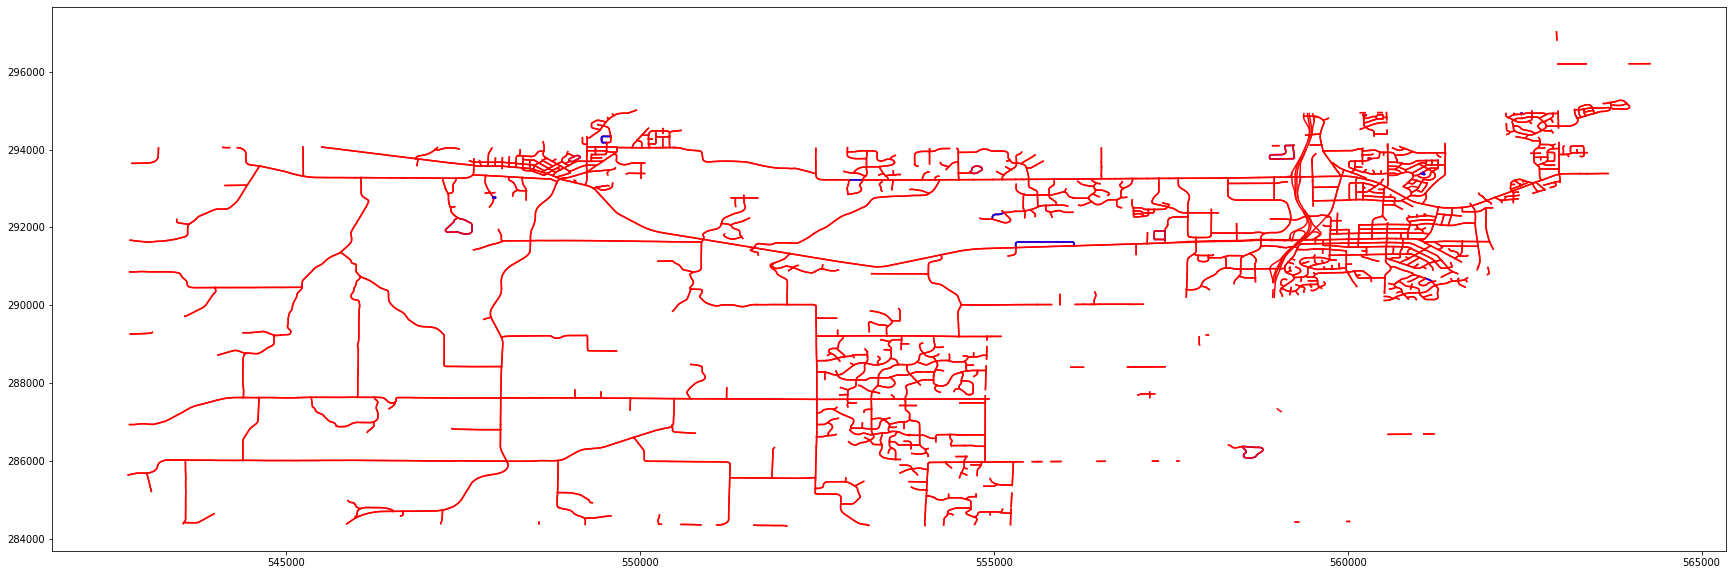

In [271]:
plt.rcParams["figure.figsize"] = (30,10)
plt.figure()

all_roadId = list(road_file['RDWY_LINK_ID'])
for sp in shape.shapeRecords():
    road_id = sp.record[43]
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    plt.plot(x,y,'r')
    
    if road_id not in all_roadId:
        plt.plot(x,y,'b')
plt.show()

# Temp : chosen road

In [272]:
# construct reference point coordinate
reference_coordinate = {}
all_roadId = list(road_file['RDWY_LINK_ID'])
for sp in shape.shapeRecords():
    road_id = sp.record[43]
    if road_id not in all_roadId:
        #print(road_id)
        continue
    start = road_file[road_file['RDWY_LINK_ID'] == road_id].iloc[0,1]
    end = road_file[road_file['RDWY_LINK_ID'] == road_id].iloc[0,2]
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    
    if  start not in reference_coordinate and sp.record[50] == 0:
        reference_coordinate[start] = [x[0],y[0]]

for sp in shape.shapeRecords():
    road_id = sp.record[43]
    if road_id not in all_roadId:
        continue
    start = road_file[road_file['RDWY_LINK_ID'] == road_id].iloc[0,1]
    end = road_file[road_file['RDWY_LINK_ID'] == road_id].iloc[0,2]
    
    
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    
    if  end not in reference_coordinate or (len(reference_coordinate[end]) > 2 and reference_coordinate[end][2] < sp.record[51]):
        reference_coordinate[end] = [x[-1],y[-1],sp.record[51]]

In [273]:
# the roadlink is in index 43
origin = 2023839
destination = 1662749

chosen_road = [819515,    4819519,    4819523,    4819524,    4819527,    4819544,    4819599,    4819644,    4819837,    4819875,    4819876,    4819929,    4819969,    4819972,    4819976,    4819977,    4830487,    4840901,    4840905,    4840909,    4840910,    4840913,    4840930,    4840985,    4841030,    4841223,    4841261,    4841262,    4841315,    4841355,    4841358,    4841362,    4841363,    4851872,    4884665,    4884666,    4884669,    4884670,    4884693,    4884694,    4884699,    4884700,    5036720,    5036721,    5036722,    5036723,    5064245,    5064246,    5098599,    5098600,    5098691,    5098692,    5098693,    5098694,    5099316,    5099317]

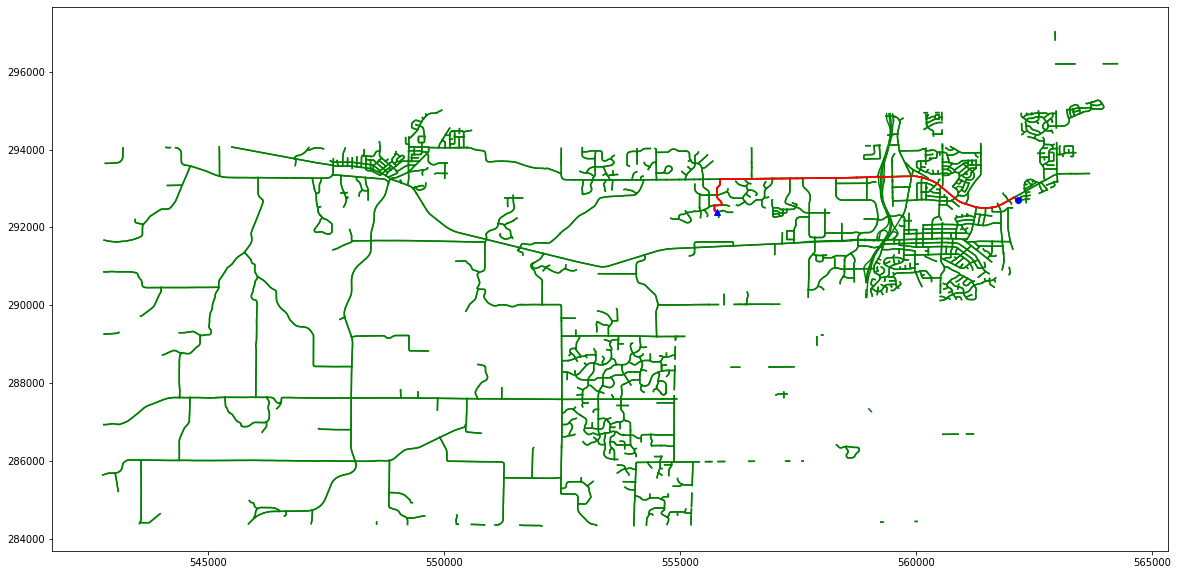

In [275]:
plt.rcParams["figure.figsize"] = (20,10)
chosen = []
plt.figure()

#plot original map 
for sp in shape.shapeRecords():
    road_id = sp.record[43]
    
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    
    if road_id in chosen_road:
        chosen.append((x,y))
    plt.plot(x,y,'g')
    
    #if road_id in [5454897]:
        #plt.plot(x,y,'r')
    
#plot shortest path
for subpath in chosen:
    plt.plot(subpath[0],subpath[1],'r')    
    #plt.plot([subpath[0][0]],[subpath[1][0]],'ro')
    
#for ref in reference_coordinate:
#    plt.plot(reference_coordinate[ref][0],reference_coordinate[ref][1],'bo')
  
plt.plot(reference_coordinate[origin][0], reference_coordinate[origin][1],'b^')
plt.plot(reference_coordinate[destination][0], reference_coordinate[destination][1],'bo')
#plt.plot(545501.9506999999, 294065.39470000006,'ro')
#plt.plot(545235.0565999998, 294068.65389999934,'ro') # start 1661833
#plt.plot(545241.4589999998, 293317.10500000045,'bo') # end 1662337


plt.show()

In [276]:
#randomly choose reference point
all_ref = list(set(list(road_file["REF_SITE_FROM_ID"]) + list(road_file["REF_SITE_TO_ID"])))
random.choice(all_ref)

1661878